# Introduction
This code simply goes through the main procedure of doing model traning, selection and evaluation. 


# Step 1: Data Input and Manipulation

In [84]:

import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from statistics import mean
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import  DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold
from scipy.stats import f_oneway
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif,f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler


import requests, zipfile
import io
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
res = requests.get(url).content

# get data
adult_raw = pd.read_csv(io.StringIO(res.decode('utf-8')), header=None)

# set columns
adult_raw.columns =['age','workclass','fnlwgt','education','education-num','marital-status',
                             'occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week',
                             'native-country','flg-50K']
# first check whether the data contains the null
adult_raw.isnull().sum()
adult_raw = adult_raw.replace([np.inf, -np.inf], np.nan).dropna()
# some data manipulation. first get the dummy variable of the y variable
adult_raw['fin_flg'] = adult_raw['flg-50K'].map(lambda x: 1 if x ==' >50K' else 0)
adult_raw = adult_raw.drop('flg-50K',axis =1)
# we use education-num as proxy for education. therefore we get rid of educatio
# country variable has too many categories. to save time, we do not use this variable. 
adult_raw = adult_raw.drop(['native-country','education'], axis = 1)

numerical = adult_raw.select_dtypes('int64')
categorical = adult_raw.select_dtypes('object')
categorical = pd.get_dummies(categorical,drop_first=True)
adult_raw['fin_flg'].value_counts()


0    24720
1     7841
Name: fin_flg, dtype: int64

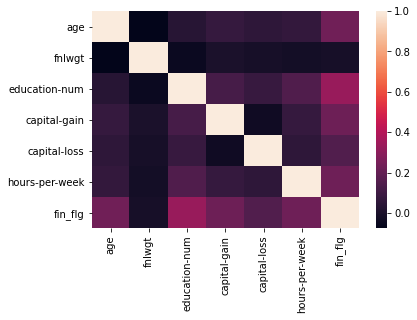

In [37]:
import seaborn
seaborn.heatmap(numerical.corr())

The result shows that there is no numerical variables that are highly correlated

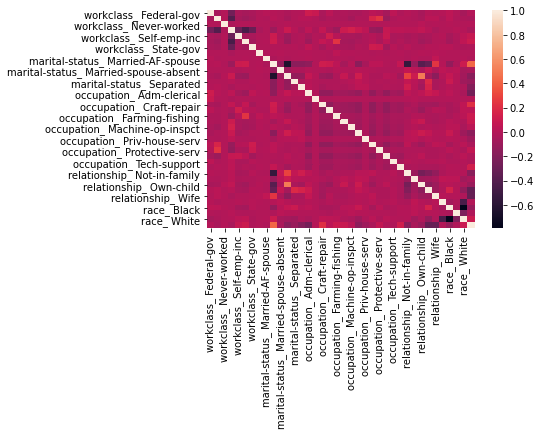

In [47]:
seaborn.heatmap(categorical.corr())

The results seems to shows that there is no large correlation between each pair of categorical variables. we next put all the variables together to see the correlations. 

In [13]:
adult = pd.concat( [numerical , categorical] , axis = 1 )
x = adult.drop('fin_flg',axis=1)
x_varname = x.columns
y = adult['fin_flg']

# Step 2: Feature selection 

In [14]:
# In the following function, I try filter method and embedded method.
# through these methods, I can get the votes for each features. I select those features with most votes
def feature_selection(feature_number):
    
    scaler = MinMaxScaler()
    scaler.fit(x)
    x_for_selection = scaler.transform (x)
    var_selected = np.empty(0)
    
    # first try fitler selection method:
    for method in [chi2, mutual_info_classif,f_classif]:
        select = SelectKBest(method, k=feature_number)
        select.fit(x_for_selection,y)
        var_selected =np.concatenate([ var_selected, x_varname[select.get_support(indices=True) ]], 0)
    
    # next try the embedded method: 
    # svc(logistics) with l1 term can filter out the coefficient near zero\
    # decision tree can output the feature importance, and can filter out those features with low importance.
    for model in [LogisticRegression( C=0.003),LogisticRegression( penalty="l1", solver ='saga', class_weight = 'balanced'),
                  RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1, class_weight = 'balanced_subsample'),
                  DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0, class_weight = 'balanced'),
                 AdaBoostClassifier (n_estimators=100,learning_rate=0.5)]:
        model_fit = model.fit(x_for_selection, y)
        #lsvc = LinearSVC( penalty="l1", dual=False).fit(x, y)
        select = SelectFromModel(model_fit, prefit=True)
        var_selected =np.concatenate([ var_selected, x_varname[select.get_support(indices=True) ]], 0)
    
    # now calculate the frequency of each variable in var_selected
    unique_elements, counts_elements = np.unique(var_selected, return_counts=True)
    counts_elements,unique_elements = (list(t) for t in zip(*sorted(zip( list(counts_elements), list(unique_elements) ))))
    unique_elements.reverse()
    return unique_elements[0:feature_number]
    # investigate the zip function!
    

In [15]:
feature_name = feature_selection(8) 
# finally we finished with the selection.
x = x.loc[:,x.columns.isin(feature_name)]
scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.transform (x)
# now we are ready for training the model

# Step 3: Model Selection via hyperparameter tuning
We next use GridsearchCV in sklearn to do hyperparameter tuning for each type algorithm. We consider the following algorithms: random forest, logisitc regression, adaboost, gradient boost, bagging with logistic regression, and svc
<p>the following links summarizes some general rule of thumbs when tuning parameters.
https://qiita.com/R1ck29/items/50ba7fa5afa49e334a8f </p>

In [91]:
# we use this function to perform hyperparameter tuning for a given algorithm.
# take parameter grid, model, and scoring as input, the function outputs the 'best' model with best score
def grid_search (param_grid, clf, score):
    #Stratification means to keep the ratio of each class in each fold.
    my_cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(clf, param_grid, cv=my_cv,scoring=score,return_train_score=True)
    grid_search.fit(x, y)
    return grid_search.best_estimator_,grid_search.best_score_,grid_search.cv_results_['std_test_score'][grid_search.best_index_] 

In [71]:
# The following function get best model from each algorithm 
def ModelSelection (criterion):
    score = criterion
    
    # we first do randomforest 
    param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
     ]
    clf = RandomForestClassifier(class_weight = 'balanced') 
    rdf_best = grid_search (param_grid, clf, score)

    # we next do logistic 
    param_grid = [
     { 'C': [0.1, 0.3, 0.6, 1]}
     ]
    clf = LogisticRegression(class_weight = 'balanced') 
    lr_best = grid_search (param_grid, clf, score) 

    # we next do adaboost
    # gridsearchCV is also useful for ensemble learning. 
    # here, notice that you may want to tune parameters both for the esembler (learning rate, number of estimators, and etc..) and the parameter 
    # for the the base estimator. you can use 'base_estimator__HyperparameterName' to tell sklearn that you are specifying the hyperparameter of base model.
    # see https://stackoverflow.com/questions/32210569/using-gridsearchcv-with-adaboost-and-decisiontreeclassifier
    # This is also time consuming. 
    param_grid = [
     { 'base_estimator__max_depth': [1,2,3,4],'n_estimators':[50,75,100,125],'learning_rate':[0.1,0.3,0.5]}
     ]
    dtc = DecisionTreeClassifier()
    clf = AdaBoostClassifier(base_estimator = dtc) 
    adb_best = grid_search (param_grid, clf, score) 

    # We next fine-tune the gradientboost. 
    # notice that gradient boost use decision tree as base estimator, so its hyperparameters naturally contains the hyperparameters of tree.
    # therefore there is no worry about the specification of 'base_estimator'
    param_grid = [
     { 'max_depth': [1,3,5],'n_estimators':[50,75,100,125],'learning_rate':[0.05,0.1,0.15,0.2]}
     ]
    clf = GradientBoostingClassifier() 
    gdb_best = grid_search (param_grid, clf, score) 
    
    # Finally we fine tune the boosting with logistics. 
    # boosting with svc is super time-consuming 
    # boosging with random forest is in fact random forest.
    param_grid = {
    'base_estimator__C' : [  0.25, 0.5, 0.75,1],
    'max_samples' : [0.05, 0.1, 0.2, 0.5]
    }
    lr = LogisticRegression(class_weight = 'balanced')
    clf = BaggingClassifier(base_estimator = lr,bootstrap=True, n_jobs=-1,max_features = 1.0,n_estimators = 20)
    bagging_lr_best = grid_search (param_grid, clf, score)
    
    # Here we do not consider svc, since it is super time consuming. In practice, however, we can use RandomizedSearchCV to choose the best
    # hyperparameters for svc
    
    return rdf_best, lr_best,adb_best, gdb_best, bagging_lr_best

In [1]:
model_result = ModelSelection('roc_auc')

# Step 4: Model(Algorithm) Comparisons using statistical tests
We now turn to statistical tests to compare the models we selected from stage 3.
<p>
main reference: Chapter 6 in 'evaluating learning algorithms a classification perspective'</p>

### a.Comparing two algorithms using 5*2 cv
In general, 
1. if you evaluate the performance of two classifiers over multiple domain, then 5*2 cv is a good choice. Paired t test via resampling is also a method, but often times the assumption for paired t test is violated. 
2. If you evaluate the performance of two classifier over one domain, then Mc Nemar contingency table test is a good choice.

In [56]:
# for comparing two classifiers using 5*2 cv
# see https://machinelearningmastery.com/hypothesis-test-for-comparing-machine-learning-algorithms/
# Also see http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_5x2cv/
from mlxtend.evaluate import paired_ttest_5x2cv
from mlxtend.evaluate import paired_ttest_5x2cv
t, p = paired_ttest_5x2cv(estimator1=clf1,estimator2=clf2,X=x_final, y=y,random_seed=1)
ttest_result =[ [model_result[i][0], model_result[j][0],   paired_ttest_5x2cv(estimator1=model_result[i][0],estimator2=model_result[j][0],X=x_final, y=y,random_seed=1)[1]] \
for i in range(0,len(model_result)-1)  for j in range(i+1,len(model_result)) ]
ttest_table = pd.DataFrame(np.vstack(ttest_result), columns= ['model1','model2','p-value'])
ttest_table
# however, pair wise comparison using t test may be misleading sometimes. 

### b.Comparing multiple algorithms 
The following code block is the functions for multiple classifier comparison and post-hoc test.
1. Parametric method: ANOVA, followed by Tukey test as post-hoc test. 
2. Nonparametric method: Friedmand test, followed by Nemenyi test as post-hoc test.



In [42]:
# Notice : I only output the statisitics. need to check the threhold value table to determine whether to reject or accept the null hypothesis.
#The algorithm is based on the 6.7.1 of 'evaluating learning algorithms a classification perspective'
def multiple_clf_compare_anova(clf_list,n):
    k = len (clf_list)
    my_cv = StratifiedKFold(n_splits=n, shuffle = False)
    pfm = [ cross_val_score (model, x, y, cv = my_cv) for model in clf_list  ]
    pfm_table = pd.DataFrame(np.vstack(pfm)).T
    # we get the results for ANOVA test. 
    # anova = f_oneway(*pfm)
    pfm_stack = pfm_table.stack ()
    ss_total = sum([(x-mean(pfm_stack ))**2 for x in pfm_stack])
    ss_pfm =   n* sum ([(x-mean(pfm_stack))**2   for x in  pfm_table.mean (axis = 0)])
    ss_block = k * sum ([(x-mean(pfm_stack))**2   for x in  pfm_table.mean (axis = 1)])
    ss_error = ss_total - (ss_pfm + ss_block)
    ms_pfm , ms_error = ss_pfm /(k-1) , ss_error /((n-1)*(k-1))
    F = ms_pfm / ms_error
    return F,pfm_table, ms_error

# The algorithm is based on the 6.7.5 of 'evaluating learning algorithms a classification perspective'
def multiple_clf_compare_friedman(clf_list,n):
    my_cv = StratifiedKFold(n_splits=n, shuffle = False)
    pfm = [ cross_val_score (model, x, y, cv = my_cv) for model in clf_list  ]
    # we get results from the friedman test 
    # please check chapter 6 of 
    pfm_table = pd.DataFrame(np.vstack(pfm)).T
    rank_table = pfm_table.rank(1, ascending=False, method='average')
    k = len (clf_list)
    friedman = 12* (np.square (rank_table.sum(axis = 0) ).sum())/(n * k * (k+1) )- 3 * n * (k +1)
    return friedman,rank_table

# if the friedman test shows that the there is difference between multiple classifiers, then do the post-doc test
#  The algorithm is based on the 6.7.7 of 'evaluating learning algorithms a classification perspective'
def post_hoc_anova (pfm_table,ms_error):
    n,k =pfm_table.shape
    avg_pfm = pfm_table.mean (axis = 0)
    divide = (ms_error/n)**0.5
    df = (n-1)*(k-1)
    return [ [i,j, (avg_pfm[i]-avg_pfm[j])/ divide ]  for i in range (0,k-1) for j in range (i+1,k)], df,k

#  The algorithm is based on the 6.7.8 of 'evaluating learning algorithms a classification perspective'
def post_hoc_friedman(rank_table):
    n,k =rank_table.shape
    avg_rank = rank_table.mean(axis = 0)  # for each classifier, get its average rank
    divide =( k*(k+1)/(6*n) )**0.5
    df = (n-1)*(k-1)
    return [ [i,j, (avg_rank[i]-avg_rank[j])/ divide ]  for i in range (0,k-1) for j in range (i+1,k)], df,k
    # the degree of freedom is (n-1)*(k-1)

In [59]:
clf_list =[ LogisticRegression (C=1),LogisticRegression (C=0.5),DecisionTreeClassifier (max_depth = 2)]
a=multiple_clf_compare_anova (clf_list,10)
a


(23.300996123007238,
           0         1         2
 0  0.836045  0.833589  0.817931
 1  0.828931  0.827088  0.825246
 2  0.838145  0.835074  0.836609
 3  0.829853  0.827088  0.817260
 4  0.835381  0.833538  0.829545
 5  0.835688  0.833845  0.828931
 6  0.840295  0.836609  0.831695
 7  0.848587  0.847359  0.836916
 8  0.843366  0.841216  0.832310
 9  0.830467  0.831388  0.825860,
 8.361668157461747e-06)

## Some Appendix 
### A. More on the Feature selection method

### Method 1 : Filter Method
I can use feature_selection library from sklearn. class SelectKBest provides the tool to find out the k 'best' variables, in the sense that they have the highest correlation with target. Since I am dealing with binary target, I can use chi2, mutual_info_classif (mutual infomration) or f_classif (ANOVA) criteria to select best feature .
see https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

In [61]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif,f_classif
# write a simple function that, use method and desired feature number as input
# output the x_new (feature data) and x_varname_selected (feature name)
def featureSelect (method_input, number_of_feature):
    select = SelectKBest(method_input, k=number_of_feature)
    x_new = select.fit_transform(x, y)
    x_varname_selected =x_varname[select.get_support(indices=True) ]
    return x_new, x_varname_selected


In [63]:
a= featureSelect(mutual_info_classif, 8)
list(a[1])

['age',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'marital-status_ Married-civ-spouse',
 'marital-status_ Never-married',
 'relationship_ Own-child']

### Method 2: Recursive elimination
Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.
Although this method works during the data training, we can still use this method to precheck the potential good features. 
however, when specifying the model, we must specify the hyperparameters. Therefore, we can actually choose number of features and model hyperparameters simultaneously. 
This method is super time consuming

In [39]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
# This is super time-consuming 
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE
svc = SVC(kernel="linear", C=1)
selector = RFE(svc, n_features_to_select=8, step=2)
selector.fit(x,y)
selector.support_


array([False, False,  True,  True,  True, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

### Method 3: Select from model (Embedded Method)

<p>Here are some 
the following link is clear and clean.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel </p>



#### a.Model selection using the L1 regularization term
remember in the textbook that l1 regularization term can be used for feature selection, since it can generate sparse coefficient matrix (many coefficients will turn to zero.) we can get rid of these features with zero coefficient. Therefore, theoretically, any model that can apply l1 regularization can be used for feature selection.
<p>
In SVC, logistic we can specify the l1 penalty (in logistic we need to specify the solver as saga). according to sklearn document, we can also set the value of C, which is the inverse of the strength of regularization. the smaller C the fewer features selected'.<\p>
        <p>
    When we set penalty to l1 and perform selectfrommodel, the default threshold is 1e-5. otherwise, the default threhold is mean(abs(coef)). I recommend use C to control. </p>
In lasso, the model automatically has l1. the default threshold is therefore 1e-5, we can use these 3 models to select feature (since here I am dealing with classification, it is better to use svc or logistics).
With Lasso, the higher the alpha parameter, the fewer features selected.

In [44]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
#lr = LogisticRegression( penalty="l1", solver ='saga').fit(x, y)
lr = LogisticRegression( C=0.003).fit(x, y)
#lsvc = LinearSVC( penalty="l1", dual=False).fit(x, y)
select = SelectFromModel(lr, prefit=True)
x_varname_selected =x_varname[select.get_support(indices=True) ]
# use lr.coef_ and select.get_support(indices=True) to check the selection

#### b. Feature selection using feature importance in decision tree
Remember that Tree-based estimators (see the sklearn.tree module and forest of trees in the sklearn.ensemble module) can be used to compute impurity-based feature importances, which in turn can be used to discard irrelevant features (when coupled with the sklearn.feature_selection.SelectFromModel meta-transformer)
<p> This implies that in general,tree type classifier can be used for feature selection based on feature importance score they output. Some commonly used classifiers are random forest, decision tree, adaboost with decision stumps. See the following link for more inoformation: https://stats.stackexchange.com/questions/51676/using-adaboost-for-feature-selection </p>


In [58]:

tree = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1).fit(x,y)
#tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0).fit(x,y)
select = SelectFromModel(tree, prefit=True)
x_varname_selected =x_varname[select.get_support(indices=True)]

## B. Choosing the best number of base clfs for iterative ensemble method
For iterative ensemble method such as adaboost and gradient boost, you can use early stopping to choose the best number of base classifiers.

In [16]:

def try_boost(model):
    skfolds = StratifiedKFold(n_splits=5) 
    best_n,min_error = [],[]
    for train_index, test_index in skfolds.split(x, y):
    # for each split, we train a gradient boost and uses early stopping to find the best number of estimator
        x_train, y_train = x[train_index],y[train_index]
        x_test, y_test =x[test_index], y[test_index]
        model.fit(x_train, y_train)
        errors = [mean_squared_error(y_test, y_pred) for y_pred in model.staged_predict(x_test)]
        best_n.append ( np.argmin(errors) + 1 )
        min_error.append (min(errors))
    return round(mean(best_n))+1, 1 - mean(min_error)

## C. Some notes on unbalanced data
We also notice that the original data set is not balanced in terms of the proportion of positive vs negative label. When data is imbalanced, the accuracy is not a good measurement. for example, if 95 percent is positive while 5 percent is negative, a classifier that always predict positive can still achieve a very high accuracy, very high precision rate and high recall rate. How to deal with this? The following is a flow of logic:
<p>Most classifiers decide the label prediciton based on a decision function (or predict_proba) and a threshold. You can actually first fit the model, get decision function, manually specify the threhold and get model's prediction based on the threshold you specify. Adjusting the threshold value gives you two important types of curves:</p>
<p>1. Recall-Precision curve. As threshold rises, recall rate declines while precision rate increase. In practice we want to a achieve a good balance between these two metrics. we mainly take f1 or weighted f1 to integrate recall and precision rate. therefore, we can choose the threshold point where f1 reaches the maximium.</p>
<p>2. ROC curve. </p>
<p>True Positive Rate = True Positives / (True Positives + False Negatives)</p>
<p>False Positive Rate = False Positives / (False Positives + True Negatives)</p>
<p>The false-positive rate is plotted on the x-axis and the true positive rate is plotted on the y-axis and the plot is referred to as the Receiver Operating Characteristic curve, or ROC curve. a classifier is ideal if it has high true positive rate and low false positive rate. Usally we calculate AUC (area under the ROC) to evaluate performance of a classifier.</p>
   <p> what do we get from above logic flow? first, we can use f1 and AUC to measure the performance of a classifier. second, we can manually adjust the threhold to achieve the most left-up point in the ROC graph, or to achieve the best f1 </p> 
see https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/#:~:text=The%20decision%20for%20converting%20a,in%20the%20range%20between%200 for the technics for doing threshold moving.</p>
<p> threshold moving, in reality, may not be a good choice. the first reason is that it is inconvenient: you have to manually choose the threhold after you fit your model, and gridsearchCV cannot be used very conveniently. Moreover, By selecting the "optimal" threshold like this, you are utilizing information post-learning, which spoils your test set (i.e., your test or validation set no longer provides an unbiased estimate of out-of-sample error). You may therefore be inducing additional over-fitting unless you choose the threshold inside a cross-validation loop on your training set only, then use it and the trained classifier with your test set. </p>
<p>Consider using class_weight if you have an unbalanced problem rather than manually setting the threshold. This should force the classifier to choose a hyperplane farther away from the class of serious interest. </p>
<p> In summary, when dealing imbalanced data, we should set class_weight to balanced, and then use f1 or auc as metrics.</p>
<p>reference:</p>
1.https://stackoverflow.com/questions/29139116/what-is-class-weight-parameter-does-in-scikit-learn-sgd
2.https://stackoverflow.com/questions/31417487/sklearn-logisticregression-and-changing-the-default-threshold-for-classification
3.https://stackoverflow.com/questions/30972029/how-does-the-class-weight-parameter-in-scikit-learn-work?rq=1